In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import accuracy_score

In [2]:
def sigmoid(x):
    """Sigmoid function, S(x) = 1/(1 + exp(-x))"""
    
    return 1/(1 + np.exp(-x))

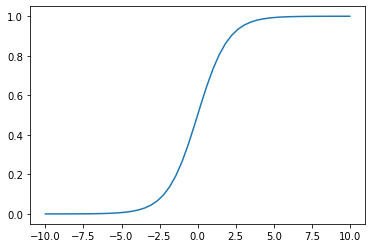

In [3]:
x = np.linspace(-10, 10)
y = sigmoid(x)

plt.plot(x, y)

The sigmoid function works well for binary classification cases because $\lim_{x \rightarrow \infty} \sigma(x) = 1$ and $\lim_{x \rightarrow -\infty} \sigma(x) = 0$.

In [4]:
def logistic_regression(X, weights, bias):
    """Perform logistic regression on data
    
    :param X: np.ndarray with data
    :param weights: Weights. Has to be as many as there are columns in X.
    :param biases: Biases. Has to be as many as there are columns in X.

    :return: np.array with probabilities.
    """
    
    return sigmoid(X @ weights + bias)


def initialise_weights_and_biases(n):
    """Initialises weights with standardnormal distribution by default, and biases as zeros.
    
    :param n: Number of weights to be generated.
    
    :return: Tuple with weights as np.array with n elements, and bias
    """
    
    weights = np.random.randn(n)
    bias = 0
    
    return weights, bias


def cross_entropy_logistic_gradient(X, y, y_hat, *parameters):
    """Computes gradient for parameters in logistic regression.
    
    :param X: np.ndarray with predictor data.
    :param y: np.array with target.
    :param y_hat: np.array of same shape as y, with predictions.
    :param *parmeters: Tuple of weights and bias. Used *args for compatibility.
    
    :return: Tuple of gradients for weights and bias.
    """
    delta = -(y - y_hat) / y.shape[0]

    dCdW = X.T @ delta
    dCdb = np.sum(delta, axis = 0)
    
    return dCdW, dCdb


def cross_entropy_loss(y, y_hat):
    """Computes cross entropy loss."""
    
    return - np.mean(y*np.log(y_hat+1e-13) + (1 - y)*np.log(1 - y_hat + 1e-13))

def train(X,
          y,
          *parameters,
          iterations=100,
          learning_rate=0.01,
          method=logistic_regression,
          gradient_func=cross_entropy_logistic_gradient,
          loss=cross_entropy_loss):
    """Trains some function estimator.
    
    :param X: np.ndarray with predictor data.
    :param y: np.ndarray with target data.
    :param *parameters: Training parameters (like weights and biases) to start with.
    :param iterations: Number of iterations to train for. 100 by default.
    :param learning_rate: Default is 0.01.
    :param method: Function with signature like `method(X, *parameters)`, that returns
                   np.array with predicted values. logistic_regression by default.
    :param gradient_func: Function that evaluates loss after a step, and returns tuple of 
                          np.array with gradients for parameters. Signature must be
                          `gradient_func(X, y, y_hat, *parameters)`. Default is
                          cross_entropy_logistic_gradient.
    :param loss: Function that returns loss. Not used for training, just for returning loss
                 after each iteration. Default is cross_entropy_loss.
    
    :return: Tuple with the first element being the updated parameters, and the second being
             the loss after each step. 
    """
    losses = np.zeros(iterations)
    for i in range(iterations):
        y_hat = method(X, *parameters)
        
        losses[i] = loss(y, y_hat)
        
        gradients = gradient_func(X, y, y_hat, *parameters)
        
        for parameter, gradient in zip(parameters, gradients):
            parameter -= learning_rate * gradient
    
    return parameters, losses

In [5]:
from sklearn.model_selection import train_test_split

titanic_df = pd.read_csv("../data/train.csv")
titanic_df["NaN_Age"] = titanic_df["Age"].isnull().astype(int)
titanic_df["Age"] = titanic_df.groupby(["Pclass", "Sex"])["Age"].apply(lambda x: x.fillna(x.median()))
# Make NaN values into "N0", so that elementwise __item__(0) and __item__(1:)
# returns either the first letter or 'N', or the number or '0' respectively
titanic_df["Cabin"] = titanic_df["Cabin"].fillna("N0")
titanic_df["Cabin_Letter"] = titanic_df["Cabin"].apply(lambda x: x[0])

# Here, it gets a bit trickyer because some people have several rooms
# This means I have to use regexp to get just the first one, and throw the others away
# I assume number of rooms is correlated with columns like fair, and that it therefore
# isn't very important. There are also not that many people that have several rooms,
# so using that data runs the risk of overfitting
titanic_df["Cabin_Number"] = titanic_df["Cabin"].str.extract(r"\w(\d{1,3})\s?.*")
titanic_df["Cabin_Number"].fillna(0, inplace=True)
titanic_df["Cabin_Number"] = titanic_df["Cabin_Number"].astype(int)
categorical_cols = ["Cabin_Letter", "Sex", "Embarked"]
titanic_df = pd.get_dummies(titanic_df, columns=categorical_cols, prefix=categorical_cols, prefix_sep='_')
X = titanic_df[["Pclass", "Age", "NaN_Age", "SibSp", "Parch", "Fare", "Sex_female",
               "Cabin_Number", "Cabin_Letter_A", "Cabin_Letter_B", "Cabin_Letter_C",
               "Cabin_Letter_D", "Cabin_Letter_E", "Cabin_Letter_F", "Cabin_Letter_G",
               "Cabin_Letter_N", "Cabin_Letter_T", "Embarked_C", "Embarked_Q", "Embarked_S"]]
y = titanic_df["Survived"]

X_train, X_test, y_train, y_test = train_test_split(X.to_numpy(), y.to_numpy(), test_size=0.2)

In [6]:
weights, bias = initialise_weights_and_biases(X_train.shape[1])
parameters, losses = train(X_train, y_train, weights, bias, iterations=10000, learning_rate=0.0025)

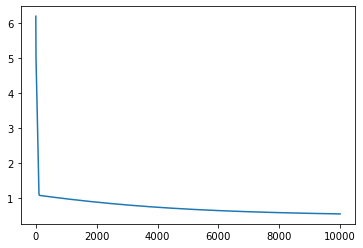

In [7]:
plt.plot(losses)

In [8]:
y_hat_test = np.round(logistic_regression(X_test, *parameters))
accuracy = accuracy_score(y_test, y_hat_test)
print(f"Accuracy = {accuracy:.2%}")

Accuracy = 83.24%
